In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/src/MA_Diffusion_base_trajectory_prediction')

from utils.data_utils import TDRIVE, GEOLIFE, load_data, calculate_bbox_and_filter, \
    plot_coordinates, plot_paths, load_new_format, find_cycles, split_cycle_in_paths, \
    plot_histograms_before_after_split, \
    get_edge_used_by_trajectories, modify_and_save_data, remove_bad_matches

from utils.shortest_path import calculate_shortest_paths

# Data Loading

In [2]:
GEOLIFE_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/geolife.h5'
TDRIVE_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/tdrive.h5'
MUNICH_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/munich.h5'
PNEUMA_PATH = '/ceph/hdd/students/schmitj/MA_Diffusion_based_trajectory_prediction/data/pNEUMA_filtered.h5'
datasets = [PNEUMA_PATH, GEOLIFE_PATH, TDRIVE_PATH, MUNICH_PATH]

In [18]:
paths, nodes, edges = load_new_format(TDRIVE_PATH)

100%|██████████| 7218/7218 [00:12<00:00, 561.80it/s]


In [19]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
degrees = [val for (node, val) in G.degree()]
print(np.mean(degrees))


3.421116999592336


# Calculate Shortest Paths for all existing actual paths in dataset

In [3]:
def calculate_shared_edge_ratio(shortest_paths, actual_paths, edges, multiple_paths=False):
    min_ratio = 0
    total_ratio = 0
    for shortest_path, actual_path in zip(shortest_paths, actual_paths):
        actual_edges = [tuple(edge) for edge in edges[actual_path['edge_idxs']]]
        if multiple_paths:
            ratios = []
            i = 0
            if len(shortest_path['edge_idxs']) == 1:
                shortest_edges = [tuple(edge) for edge in edges[shortest_path['edge_idxs'][0]]]
                shared_edges = set(shortest_edges) & set(actual_edges)
                ratio = len(shared_edges) / len(actual_edges)
                max_ratio = ratio
            else:
                while i < len(shortest_path['edge_idxs']):
                    shortest_edges = [tuple(edge) for edge in edges[shortest_path['edge_idxs'][i]]]
                    shared_edges = set(shortest_edges) & set(actual_edges)
                    ratio = len(shared_edges) / len(actual_edges)
                    ratios.append(ratio)
                    i += 1
                max_ratio = np.max(ratios)
        else:
            shortest_edges = [tuple(edge) for edge in edges[shortest_path['edge_idxs']]]
            shared_edges = set(shortest_edges) & set(actual_edges)
            ratio = len(shared_edges) / len(actual_edges)
            max_ratio = ratio

        total_ratio += max_ratio
            
    average_ratio = total_ratio / len(shortest_paths)
    
    return average_ratio


In [4]:
def calculate_path_distances(shortest_paths, actual_paths, node_coordinates, edges):
    ## Actual Paths
    # Calculate distance in terms of # edges
    actual_path_lengths = [len(path['edge_idxs']) for path in actual_paths]
    mean_actual_path_length = np.mean(actual_path_lengths)
    median_actual_path_length = np.median(actual_path_lengths)
    # Calculate distance in terms of euclidean distance
    actual_euclidean_lengths = np.zeros(len(actual_paths))
    for j, path in enumerate(actual_paths):
        euclidean_length = 0
        for i in range(len(path['edge_idxs'])):
            edge_idx = path['edge_idxs'][i]
            edge_coordinates = node_coordinates[edges[edge_idx]]
            euclidean_length += np.linalg.norm(edge_coordinates[1] - edge_coordinates[0])
        actual_euclidean_lengths[j] = euclidean_length
    mean_actual_euclidean_path_length = np.mean(actual_euclidean_lengths)
    median_actual_euclidean_path_length = np.median(actual_euclidean_lengths)
    
    ## Shortest Paths
    # Calculate distance in terms of # edges
    shortest_path_lengths = [len(path['edge_idxs']) for path in shortest_paths]
    mean_shortest_path_length = np.mean(shortest_path_lengths)
    median_shortest_path_length = np.median(shortest_path_lengths)
    # Calculate distance in terms of euclidean distance
    shortest_euclidean_lengths = np.zeros(len(shortest_paths))
    for j, path in enumerate(shortest_paths):
        euclidean_length = 0
        for i in range(len(path['edge_idxs'])):
            edge_idx = path['edge_idxs'][i]
            edge_coordinates = node_coordinates[edges[edge_idx]]
            euclidean_length += np.linalg.norm(edge_coordinates[1] - edge_coordinates[0])
        shortest_euclidean_lengths[j] = euclidean_length
    mean_shortest_euclidean_path_length = np.mean(shortest_euclidean_lengths)
    median_shortest_euclidean_path_length = np.median(shortest_euclidean_lengths)
    
    return (mean_actual_path_length, median_actual_path_length, mean_actual_euclidean_path_length, median_actual_euclidean_path_length, 
            mean_shortest_path_length, median_shortest_path_length, mean_shortest_euclidean_path_length, median_shortest_euclidean_path_length)

In [5]:
def calculate_ade(shortest_paths, actual_paths, node_coordinates, edges, norm=None, n_points=5, multiple_paths=False):
    """_summary_

    Args:
        shortest_paths (_type_): List of shortest paths
        actual_paths (_type_): List of actual paths
        node_coordinates (_type_): List of node coordinates
        edges (_type_): List of edges, which are in themselves lists of nodes
        norm (_type_, optional): 1 for L1-norm. Defaults to None, i.e. the L2 Norm.
        n_points (_type_, optional): Number of points to calculate the ADE for. Defaults to 5.

    Returns:
        ADE: Average displacement error
    """
    total_ade = 0
    for shortest_path, actual_path in zip(shortest_paths, actual_paths):
        ade = 0
        if multiple_paths:
            ades = []
            i = 0
            if len(shortest_path['edge_idxs']) == 1:
                n_points_act = n_points if n_points < len(shortest_path['edge_idxs'][0]) else len(shortest_path['edge_idxs'][0])
                if len(shortest_path['edge_idxs'][0]) > 0:
                    min_length = np.min([len(shortest_path['edge_idxs'][0]), len(actual_path['edge_idxs'])])
                    for i in range(min_length - 1, min_length - n_points_act, -1):
                        shortest_edge = edges[shortest_path['edge_idxs'][0][i]]
                        shortest_edge_coordinates = node_coordinates[shortest_edge]
                        actual_edge = edges[actual_path['edge_idxs'][i]]
                        actual_edge_coordinates = node_coordinates[actual_edge]
                        ade += np.linalg.norm(shortest_edge_coordinates - actual_edge_coordinates, ord=norm)
                    ade /= len(shortest_path['edge_idxs'][0])
                min_ade = ade
            else:
                while i < len(shortest_path['edge_idxs']):
                    n_points_act = n_points if n_points < len(shortest_path['edge_idxs'][i]) else len(shortest_path['edge_idxs'][i])
                    if len(shortest_path['edge_idxs'][i]) > 0:
                        min_length = np.min([len(shortest_path['edge_idxs'][i]), len(actual_path['edge_idxs'])])
                        for j in range(min_length - 1, min_length - n_points_act, -1):
                            shortest_edge = edges[shortest_path['edge_idxs'][i][j]]
                            shortest_edge_coordinates = node_coordinates[shortest_edge]
                            actual_edge = edges[actual_path['edge_idxs'][j]]
                            actual_edge_coordinates = node_coordinates[actual_edge]
                            ade += np.linalg.norm(shortest_edge_coordinates - actual_edge_coordinates, ord=norm)
                        ade /= len(shortest_path['edge_idxs'][i])
                    else:
                        n_points_act = n_points
                    ades.append(ade)
                    i += 1
                min_ade = np.min(ades)
            total_ade += min_ade
        else:
            n_points_act = n_points if n_points < len(shortest_path['edge_idxs']) else len(shortest_path['edge_idxs'])
            if len(shortest_path['edge_idxs']) > 0:
                min_length = np.min([len(shortest_path['edge_idxs']), len(actual_path['edge_idxs'])])
                for i in range(min_length - 1, min_length - n_points_act, -1):
                    shortest_edge = edges[shortest_path['edge_idxs'][i]]
                    shortest_edge_coordinates = node_coordinates[shortest_edge]
                    actual_edge = edges[actual_path['edge_idxs'][i]]
                    actual_edge_coordinates = node_coordinates[actual_edge]
                    ade += np.linalg.norm(shortest_edge_coordinates - actual_edge_coordinates, ord=norm)
                ade /= len(shortest_path['edge_idxs'])
                total_ade += ade
            else:
                n_points_act = n_points
    return total_ade / len(shortest_paths)

In [6]:
def shortest_equal_actual(shortest_paths, actual_paths):
    equal = 0
    for shortest_path, actual_path in zip(shortest_paths, actual_paths):
        i = 0
        if len(shortest_path['edge_idxs']) == 1:
            if np.array_equal(np.array(shortest_path['edge_idxs'][0]), np.array(actual_path['edge_idxs'])):
                equal += 1
        else:
            while i < len(shortest_path['edge_idxs']):
                if np.array_equal(np.array(shortest_path['edge_idxs'][i]), np.array(actual_path['edge_idxs'])):
                    equal += 1
                i += 1
    return equal / len(shortest_paths)

## Shortest Paths in Terms of # Edges

In [7]:
import numpy as np
# Calculate mean and median path lengths for actual paths and shortest paths
actual_mean_lengths = []
actual_median_lengths = []
shortest_mean_lengths = []
shortest_median_lengths = []
actual_mean_euclidean_length = []
actual_median_euclidean_length = []
shortest_mean_euclidean_length = []
shortest_median_euclidean_length = []
shared_edges_average = []
ade_scores = []
equal_paths = []

for dataset in tqdm(datasets):
    paths, node_coordinates, edges = load_new_format(dataset)
    shortest_paths = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='edge')
    shortest_paths_mult = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='edge', multiple_paths=True)
    ade = calculate_ade(shortest_paths_mult, paths, node_coordinates, edges, norm=None, n_points=5, multiple_paths=True)
    ade_scores.append(ade)

    # Calculate mean and median path lengths in number of edges and in euclidean terms
    (mean_actual_path_length, 
        median_actual_path_length, 
        mean_actual_euclidean_path_length, 
        median_actual_euclidean_path_length, 
        mean_shortest_path_length, 
        median_shortest_path_length, 
        mean_shortest_euclidean_path_length, 
        median_shortest_euclidean_path_length) = calculate_path_distances(shortest_paths, paths, node_coordinates, edges)

    # Actual Paths
    actual_mean_lengths.append(mean_actual_path_length)
    actual_median_lengths.append(median_actual_path_length)
    actual_mean_euclidean_length.append(mean_actual_euclidean_path_length)
    actual_median_euclidean_length.append(median_actual_euclidean_path_length)

    # Shortest Paths
    shortest_mean_lengths.append(mean_shortest_path_length)
    shortest_median_lengths.append(median_shortest_path_length)
    shortest_mean_euclidean_length.append(mean_shortest_euclidean_path_length)
    shortest_median_euclidean_length.append(median_shortest_euclidean_path_length)

    # Shared edges
    average_ratio = calculate_shared_edge_ratio(shortest_paths_mult, paths, edges, multiple_paths=True)
    shared_edges_average.append(average_ratio)
    
    # Equal Paths
    equal_paths.append(shortest_equal_actual(shortest_paths_mult, paths))


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [1:02:04<00:00, 931.17s/it]


### Number of Edges

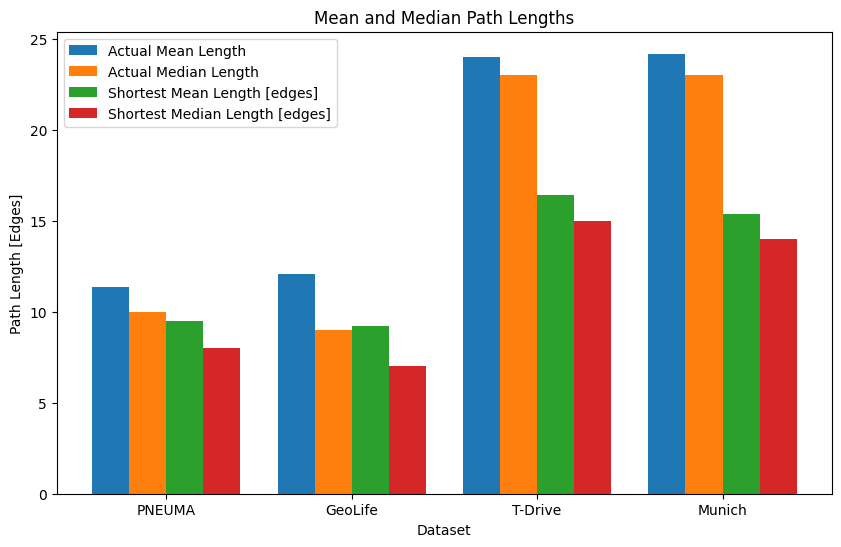

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_lengths, bar_width, label='Actual Mean Length')
plt.bar(index + bar_width, actual_median_lengths, bar_width, label='Actual Median Length')
plt.bar(index + 2 * bar_width, shortest_mean_lengths, bar_width, label='Shortest Mean Length [edges]')
plt.bar(index + 3 * bar_width, shortest_median_lengths, bar_width, label='Shortest Median Length [edges]')

plt.xticks(index + 1.5 * bar_width, ['PNEUMA', 'GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Edges]')
plt.title('Mean and Median Path Lengths')
plt.legend()
plt.show()

### Euclidean Path Lengths

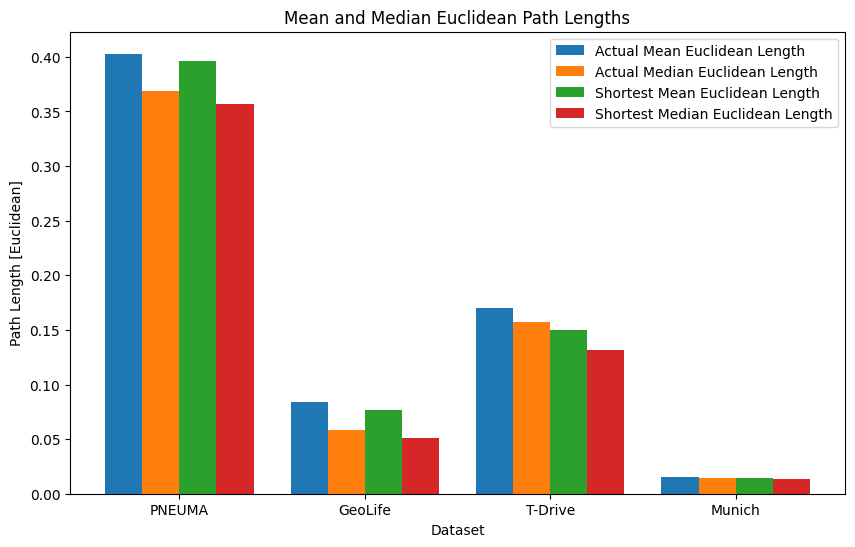

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_euclidean_length, bar_width, label='Actual Mean Euclidean Length')
plt.bar(index + bar_width, actual_median_euclidean_length, bar_width, label='Actual Median Euclidean Length')
plt.bar(index + 2 * bar_width, shortest_mean_euclidean_length, bar_width, label='Shortest Mean Euclidean Length')
plt.bar(index + 3 * bar_width, shortest_median_euclidean_length, bar_width, label='Shortest Median Euclidean Length')

plt.xticks(index + 1.5 * bar_width, ['PNEUMA', 'GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Euclidean]')
plt.title('Mean and Median Euclidean Path Lengths')
plt.legend()
plt.show()

In [10]:
print("Using edge weighting of 1:")
for i, dataset in enumerate(datasets):
    print("Dataset:", str(dataset).split('/')[-1].split('.')[0])
    print(f"Average length of actual paths: {np.round(actual_mean_lengths[i], 2)} edges, or {round(actual_mean_euclidean_length[i], 4)} in euclidean length")
    print(f"Average length of shortest paths: {np.round(shortest_mean_lengths[i], 2)} edges, or {round(shortest_mean_euclidean_length[i], 4)} in euclidean length")
    print(f'Actual paths have on average {round(actual_mean_lengths[i] / shortest_mean_lengths[i], 2)} times more edges than the shortest available paths')
    print(f'Actual paths are on average {round(actual_mean_euclidean_length[i] / shortest_mean_euclidean_length[i], 2)} times longer in euclidean distance than the shortest available paths (euclidean)')
    print("Average ratio of shared edges:", np.round(shared_edges_average[i], 4))
    print(f"ADE:", np.round(ade_scores[i], 4))
    print(f"Average ratio of equal shortest and actual paths", np.round(equal_paths[i], 4))
    print("\n")

Using edge weighting of 1:
Dataset: pNEUMA_filtered
Average length of actual paths: 11.35 edges, or 0.4029 in euclidean length
Average length of shortest paths: 9.5 edges, or 0.3959 in euclidean length
Actual paths have on average 1.2 times more edges than the shortest available paths
Actual paths are on average 1.02 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.6499
ADE: 0.0292
Average ratio of equal shortest and actual paths 0.4033


Dataset: geolife
Average length of actual paths: 12.06 edges, or 0.0837 in euclidean length
Average length of shortest paths: 9.23 edges, or 0.0768 in euclidean length
Actual paths have on average 1.31 times more edges than the shortest available paths
Actual paths are on average 1.09 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.4981
ADE: 0.0075
Average ratio of equal shortest and actual paths 0.2679


Dataset: tdrive
A

## Shortest Paths in Terms of Euclidean Distance

In [11]:
import numpy as np
# Calculate mean and median path lengths for actual paths and shortest paths
actual_mean_lengths = []
actual_median_lengths = []
shortest_mean_lengths = []
shortest_median_lengths = []
actual_mean_euclidean_length = []
actual_median_euclidean_length = []
shortest_mean_euclidean_length = []
shortest_median_euclidean_length = []
shared_edges_average = []
ade_scores = []
equal_paths = []

for dataset in tqdm(datasets):
    paths, node_coordinates, edges = load_new_format(dataset)
    shortest_paths = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='euclidean')
    shortest_paths_mult = calculate_shortest_paths(paths, node_coordinates, edges, distance_measure='euclidean', multiple_paths=True)
    ade = calculate_ade(shortest_paths_mult, paths, node_coordinates, edges, norm=None, n_points=5, multiple_paths=True)
    ade_scores.append(ade)
    
    # Calculate mean and median path lengths in number of edges and in euclidean terms
    (mean_actual_path_length, 
     median_actual_path_length, 
     mean_actual_euclidean_path_length, 
     median_actual_euclidean_path_length, 
     mean_shortest_path_length, 
     median_shortest_path_length, 
     mean_shortest_euclidean_path_length, 
     median_shortest_euclidean_path_length) = calculate_path_distances(shortest_paths, paths, node_coordinates, edges)
    
    # Actual Paths
    actual_mean_lengths.append(mean_actual_path_length)
    actual_median_lengths.append(median_actual_path_length)
    actual_mean_euclidean_length.append(mean_actual_euclidean_path_length)
    actual_median_euclidean_length.append(median_actual_euclidean_path_length)
    
    # Shortest Paths
    shortest_mean_lengths.append(mean_shortest_path_length)
    shortest_median_lengths.append(median_shortest_path_length)
    shortest_mean_euclidean_length.append(mean_shortest_euclidean_path_length)
    shortest_median_euclidean_length.append(median_shortest_euclidean_path_length)
    
    # Shared edges
    average_ratio = calculate_shared_edge_ratio(shortest_paths_mult, paths, edges, multiple_paths=True)
    shared_edges_average.append(average_ratio)
    
    # Equal Paths
    equal_paths.append(shortest_equal_actual(shortest_paths_mult, paths))


100%|██████████| 4/4 [46:09<00:00, 692.39s/it]


### Number of Edges

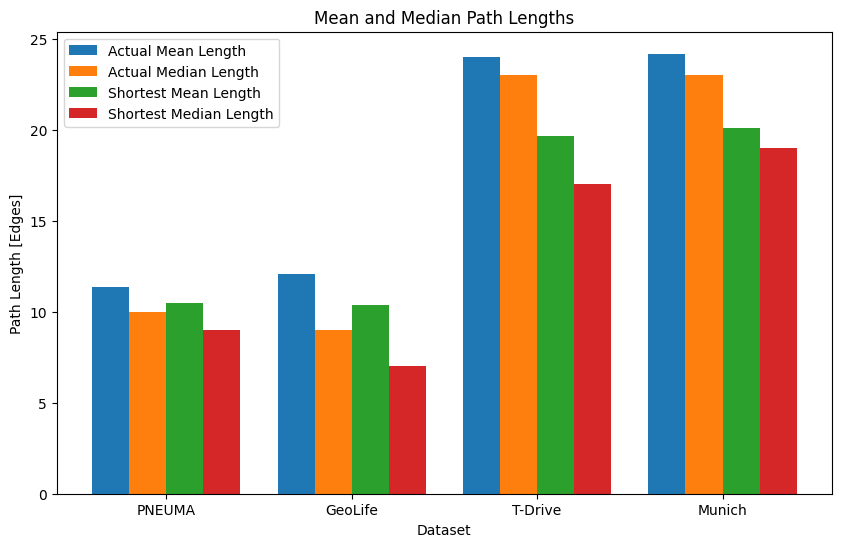

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_lengths, bar_width, label='Actual Mean Length')
plt.bar(index + bar_width, actual_median_lengths, bar_width, label='Actual Median Length')
plt.bar(index + 2 * bar_width, shortest_mean_lengths, bar_width, label='Shortest Mean Length')
plt.bar(index + 3 * bar_width, shortest_median_lengths, bar_width, label='Shortest Median Length')

plt.xticks(index + 1.5 * bar_width, ['PNEUMA', 'GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Edges]')
plt.title('Mean and Median Path Lengths')
plt.legend()
plt.show()

### Euclidean Path Length

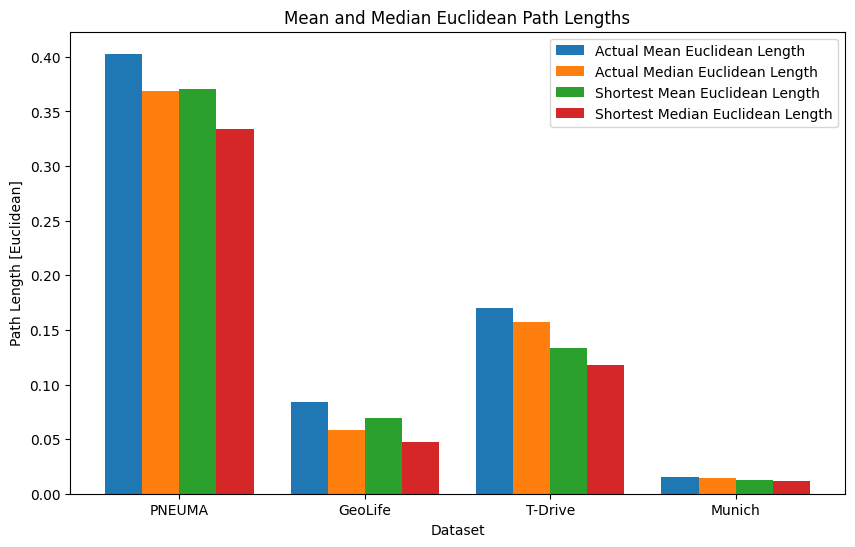

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(datasets))

plt.bar(index, actual_mean_euclidean_length, bar_width, label='Actual Mean Euclidean Length')
plt.bar(index + bar_width, actual_median_euclidean_length, bar_width, label='Actual Median Euclidean Length')
plt.bar(index + 2 * bar_width, shortest_mean_euclidean_length, bar_width, label='Shortest Mean Euclidean Length')
plt.bar(index + 3 * bar_width, shortest_median_euclidean_length, bar_width, label='Shortest Median Euclidean Length')

plt.xticks(index + 1.5 * bar_width, ['PNEUMA', 'GeoLife', 'T-Drive', 'Munich'])
plt.xlabel('Dataset')
plt.ylabel('Path Length [Euclidean]')
plt.title('Mean and Median Euclidean Path Lengths')
plt.legend()
plt.show()

In [14]:
print("Using edge distance as distance measure")
for i, dataset in enumerate(datasets):
    print("Dataset:", str(dataset).split('/')[-1].split('.')[0])
    print(f"Average length of actual paths: {np.round(actual_mean_lengths[i], 2)} edges, or {round(actual_mean_euclidean_length[i], 4)} in euclidean length")
    print(f"Average length of shortest paths: {np.round(shortest_mean_lengths[i], 2)} edges, or {round(shortest_mean_euclidean_length[i], 4)} in euclidean length")
    print(f'Actual paths have on average {round(actual_mean_lengths[i] / shortest_mean_lengths[i], 2)} times more edges than the shortest available paths')
    print(f'Actual paths are on average {round(actual_mean_euclidean_length[i] / shortest_mean_euclidean_length[i], 2)} times longer in euclidean distance than the shortest available paths (euclidean)')
    print("Average ratio of shared edges:", np.round(shared_edges_average[i], 4))
    print(f"ADE:", np.round(ade_scores[i], 4))
    print(f"Average ratio of equal shortest and actual paths", np.round(equal_paths[i], 4))
    print("\n")

Using edge distance as distance measure
Dataset: pNEUMA_filtered
Average length of actual paths: 11.35 edges, or 0.4029 in euclidean length
Average length of shortest paths: 10.45 edges, or 0.3708 in euclidean length
Actual paths have on average 1.09 times more edges than the shortest available paths
Actual paths are on average 1.09 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.6439
ADE: 0.0241
Average ratio of equal shortest and actual paths 0.3799


Dataset: geolife
Average length of actual paths: 12.06 edges, or 0.0837 in euclidean length
Average length of shortest paths: 10.36 edges, or 0.0694 in euclidean length
Actual paths have on average 1.16 times more edges than the shortest available paths
Actual paths are on average 1.21 times longer in euclidean distance than the shortest available paths (euclidean)
Average ratio of shared edges: 0.4578
ADE: 0.0063
Average ratio of equal shortest and actual paths 0.2111




## Plot Actual and Shortest Paths

49426


  0%|          | 0/2 [00:00<?, ?it/s]


KeyError: 'coordinates'

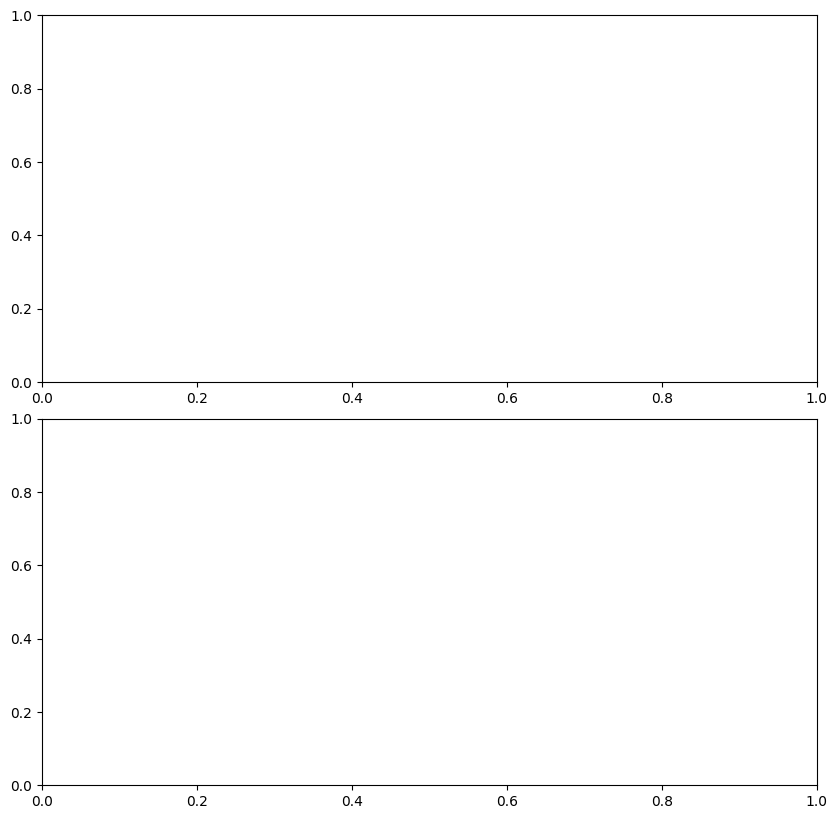

In [ ]:
path_id = np.random.randint(low=0, high=len(paths))
print(path_id)
plot_paths(paths, node_coordinates, edges, num_paths_to_plot=2, start_id=path_id)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


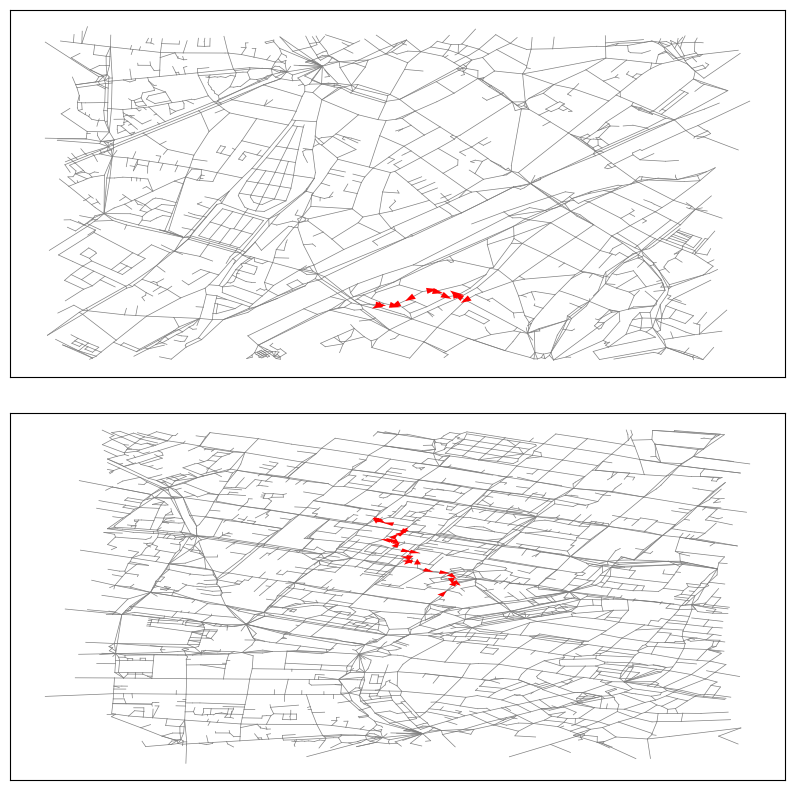

In [ ]:
plot_paths(shortest_paths, node_coordinates, edges, num_paths_to_plot=2, start_id=path_id)

In [6]:
for d in datasets:
    paths_, node_coordinates_, edges_ = load_new_format(d)
    print(paths_[0].keys())
    print("\n")

100%|██████████| 91874/91874 [01:26<00:00, 1068.28it/s]


dict_keys(['edge_idxs', 'num_observations_per_edge', 'raw_idx_to_edge_idx', 'edge_orientations'])




100%|██████████| 29458/29458 [01:19<00:00, 372.20it/s]


dict_keys(['coordinates', 'distance_observation_to_matched_edge', 'edge_idxs', 'edge_observation_ranges', 'edge_orientations', 'mode_ranges', 'modes', 'range', 'record_file', 'timestamps', 'user_idx'])




100%|██████████| 7218/7218 [00:13<00:00, 546.34it/s]


dict_keys(['coordinates', 'distance_observation_to_matched_edge', 'edge_idxs', 'edge_observation_ranges', 'edge_orientations', 'taxi_idx', 'timestamps'])




100%|██████████| 2866/2866 [00:03<00:00, 760.37it/s]

dict_keys(['coordinates', 'distance_observation_to_matched_edge', 'edge_idxs', 'edge_observation_ranges', 'edge_orientations', 'timestamps'])




In [13]:
paths_, node_coordinates_, edges_ = load_new_format(TDRIVE_PATH)

100%|██████████| 7218/7218 [00:13<00:00, 553.87it/s]


In [21]:
for i in range(50):
    print(paths_[i]['distance_observation_to_matched_edge'])

[9.33784975e-04 9.54554456e-04 1.04574773e-03 9.14823227e-04
 1.09901752e-03 4.20517842e-04 5.17848761e-04 2.28961030e-03
 1.07332449e-03 5.45528616e-04 1.42923480e-04 5.44639909e-05
 2.26985984e-05 1.66430154e-04]
[1.19196383e-03 5.91155172e-06 1.56012299e-05 2.92618138e-04]
[0.00125774 0.00137193 0.00142548 0.00122893 0.0013497  0.00133404
 0.00139719 0.00138101 0.00141587 0.00133352 0.0014831  0.00125471
 0.0012734  0.00124814 0.00139114 0.00130826 0.00133352 0.00119104
 0.00136233 0.00133352 0.00135878 0.00141942 0.00120367 0.00110514
 0.00125116 0.00116578 0.00124814 0.0014356  0.00131484 0.00118802
 0.00100002 0.00124156 0.00128603 0.00126077 0.00122946 0.00122038
 0.00123603 0.00132747 0.00134312 0.00132799 0.00134615 0.0013497
 0.00129563 0.00130826 0.00133707 0.00117131 0.00132391 0.00112987
 0.00123196 0.00120012 0.00116223 0.00112434 0.00126379 0.00143508
 0.00136233 0.00120367 0.00132089 0.00132444 0.00137496 0.00133352
 0.00123551 0.00118446 0.00104146 0.0010733  0.0011778

In [3]:
max_dist_abs = []
mean_dist = []
for i in range(len(paths_)):
    if len(paths_[i]['distance_observation_to_matched_edge']) > 0:
        max_dist_abs.append(np.max(paths_[i]['distance_observation_to_matched_edge']))
        mean_dist.append(np.mean(paths_[i]['distance_observation_to_matched_edge']))
threshold = np.percentile(max_dist_abs, 95)


NameError: name 'paths_' is not defined

In [24]:
print(np.max(max_dist_abs))
print(np.percentile(max_dist_abs, 95))
print(np.median(max_dist_abs))
print(np.mean(max_dist_abs))

0.2684424331732131
0.006459977010970721
0.0018124783030721667
0.0032236193807234407


In [26]:
print(np.max(mean_dist))
print(np.percentile(mean_dist, 95))
print(np.median(mean_dist))
print(np.mean(mean_dist))

0.1960463716671651
0.0033012891206073585
0.0007722452218861215
0.0014454879617405649


In [6]:
for d in datasets[1:3]:
    print("Dataset:", str(d).split('/')[-1].split('.')[0])
    paths_, node_coordinates_, edges_ = load_new_format(d)
    print("# Paths before:", len(paths_))
    new_paths_max, bad_matches_max = remove_bad_matches(paths_, mode='max')
    print("# Paths using max cleaning:", len(new_paths_max))
    new_paths_mean, bad_matches_mean = remove_bad_matches(paths_, mode='mean')
    print("# Paths using mean cleaning:", len(new_paths_mean))
    print("\n")

Dataset: geolife


100%|██████████| 29458/29458 [01:15<00:00, 391.84it/s]


# Paths before: 29458


100%|██████████| 29458/29458 [00:00<00:00, 202905.76it/s]


# Paths using max cleaning: 27980


100%|██████████| 29458/29458 [00:00<00:00, 121308.45it/s]


# Paths using mean cleaning: 27980


Dataset: tdrive


100%|██████████| 7218/7218 [00:12<00:00, 574.76it/s]


# Paths before: 7218


100%|██████████| 7218/7218 [00:00<00:00, 223297.75it/s]


# Paths using max cleaning: 6797


100%|██████████| 7218/7218 [00:00<00:00, 113439.85it/s]


# Paths using mean cleaning: 6797




In [3]:
paths, node_coordinates, edges = load_new_format(TDRIVE_PATH)
edge_coordinates = node_coordinates[edges]

100%|██████████| 7218/7218 [00:13<00:00, 537.29it/s]


In [5]:
new_paths_max, bad_matches_max = remove_bad_matches(paths, mode='max')
new_paths_mean, bad_matches_mean = remove_bad_matches(paths, mode='mean')

100%|██████████| 7218/7218 [00:00<00:00, 122540.49it/s]


 25%|██▌       | 1/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


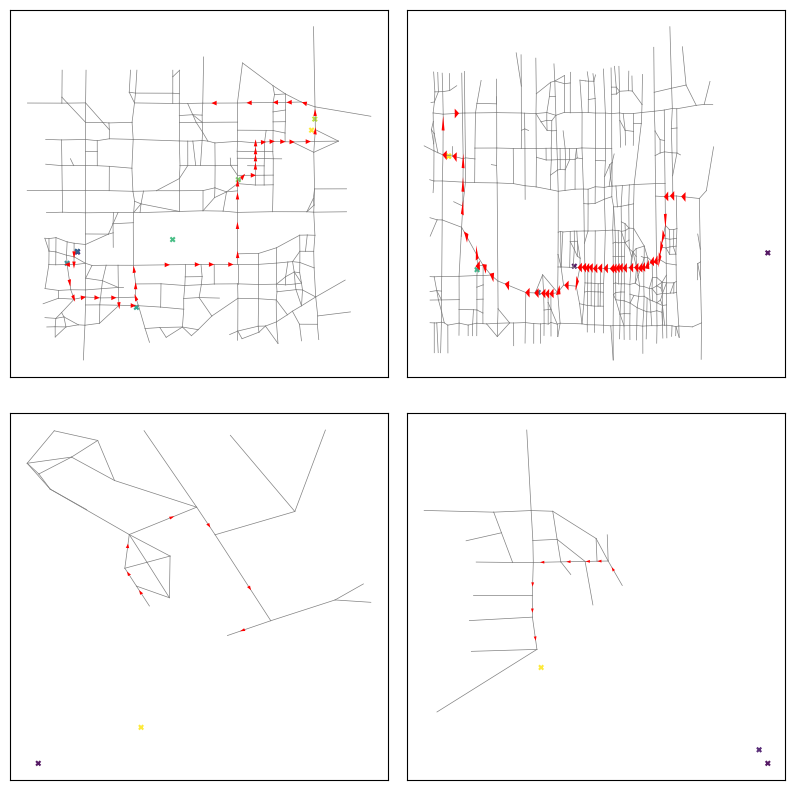

In [9]:
plot_paths(bad_matches_max, node_coordinates, edges, num_paths_to_plot=4, start_id=np.random.randint(low=0, high=len(bad_matches_max)))

100%|██████████| 4/4 [00:00<00:00, 12.95it/s]


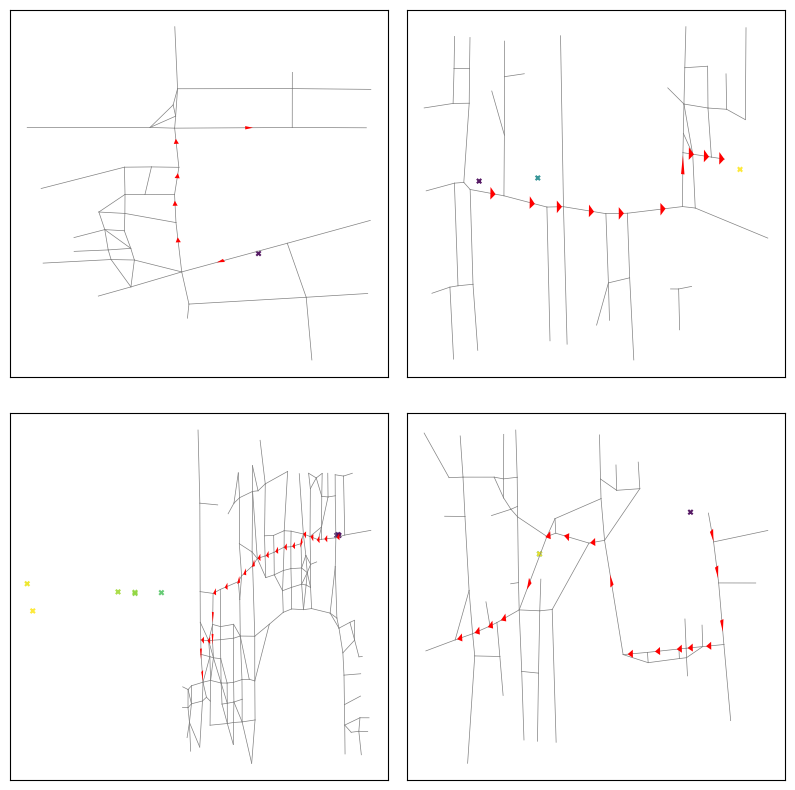

In [10]:
plot_paths(bad_matches_mean, node_coordinates, edges, num_paths_to_plot=4, start_id=np.random.randint(low=0, high=len(bad_matches_mean)))